<a href="https://colab.research.google.com/github/RajeswariKumaran/SSLMethodsAnalysis/blob/main/Two_moon_cifar10_vat_perturbations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Visualisation of perturbations

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10, batch_size=1, shuffle=True)

images, _ = next(iter(loader))  # one image
images = images.cuda()


100%|██████████| 170M/170M [00:03<00:00, 49.3MB/s]


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model = SimpleCNN().cuda()
model.eval()  # Important for VAT


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
def generate_vat_perturbation(model, x, epsilon=2.0, xi=1e-6, num_iters=1):
    d = torch.randn_like(x).cuda()
    d = F.normalize(d, p=2, dim=(1,2,3))

    with torch.no_grad():
        pred = F.softmax(model(x), dim=1)

    for _ in range(num_iters):
        d.requires_grad_()
        pred_hat = F.log_softmax(model(x + xi * d), dim=1)
        loss = F.kl_div(pred_hat, pred, reduction='batchmean')
        grad = torch.autograd.grad(loss, d)[0]
        d = F.normalize(grad, p=2, dim=(1,2,3)).detach()

    r_adv = epsilon * d
    return r_adv


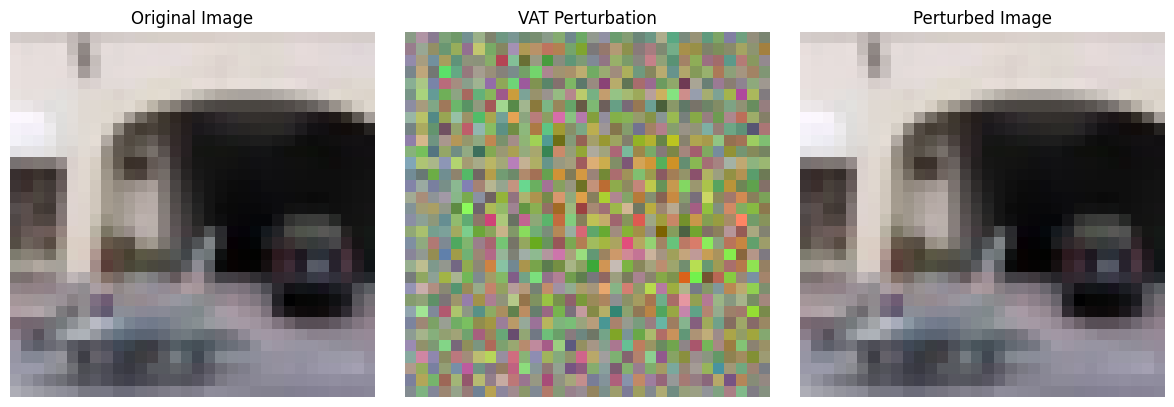

In [ ]:
# Get the perturbation
r_vadv = generate_vat_perturbation(model, images)
x_vadv = images + r_vadv

# Move tensors to CPU for plotting
orig = images[0].detach().cpu().permute(1, 2, 0).numpy()
perturb = r_vadv[0].detach().cpu().permute(1, 2, 0).numpy()
perturbed_img = x_vadv[0].detach().cpu().permute(1, 2, 0).numpy()

# Normalize for display
def normalize(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(normalize(orig))
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(normalize(perturb))
axs[1].set_title("VAT Perturbation")
axs[1].axis("off")

axs[2].imshow(normalize(perturbed_img))
axs[2].set_title("Perturbed Image")
axs[2].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
#pertubations with labeling

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 class labels
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# 1. Load one CIFAR-10 image
transform = transforms.Compose([transforms.ToTensor()])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10, batch_size=1, shuffle=True)
images, labels = next(iter(loader))
images = images.cuda()
labels = labels.cuda()

# 2. Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model = SimpleCNN().cuda()
model.eval()


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
def generate_vat_perturbation(model, x, epsilon=2.0, xi=1e-6, num_iters=1):
    d = torch.randn_like(x).cuda()
    d = F.normalize(d, p=2, dim=(1,2,3))

    with torch.no_grad():
        pred = F.softmax(model(x), dim=1)

    for _ in range(num_iters):
        d.requires_grad_()
        pred_hat = F.log_softmax(model(x + xi * d), dim=1)
        loss = F.kl_div(pred_hat, pred, reduction='batchmean')
        grad = torch.autograd.grad(loss, d)[0]
        d = F.normalize(grad, p=2, dim=(1,2,3)).detach()

    r_adv = epsilon * d
    return r_adv


In [ ]:
# Generate VAT perturbation and perturbed input
r_vadv = generate_vat_perturbation(model, images)
x_vadv = images + r_vadv

# Get model predictions
with torch.no_grad():
    pred_orig = model(images)
    pred_pert = model(x_vadv)

# Get predicted class indices
pred_class_orig = pred_orig.argmax(dim=1).item()
pred_class_pert = pred_pert.argmax(dim=1).item()
true_class = labels.item()

# Convert to class names
true_label_name = cifar10_classes[true_class]
pred_label_orig_name = cifar10_classes[pred_class_orig]
pred_label_pert_name = cifar10_classes[pred_class_pert]


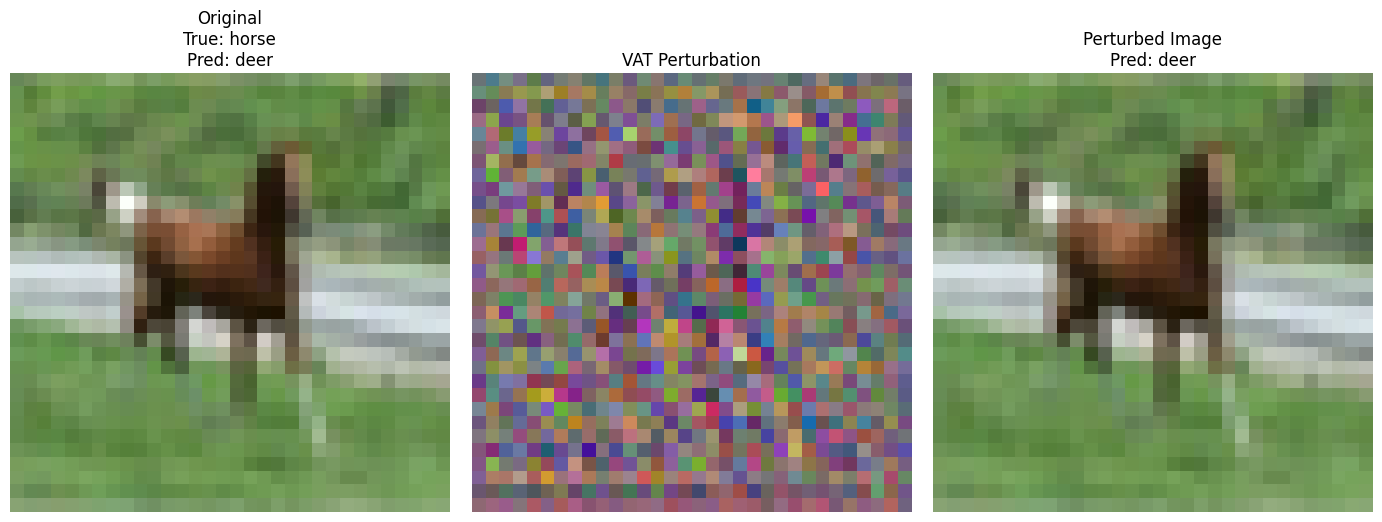

In [ ]:
# Convert tensors to NumPy for plotting
def to_img(x):
    return x.detach().cpu().permute(1, 2, 0).numpy()

def normalize(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Prepare images
orig = to_img(images[0])
perturb = to_img(r_vadv[0])
perturbed_img = to_img(x_vadv[0])

# Plot
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

axs[0].imshow(normalize(orig))
axs[0].set_title(f"Original\nTrue: {true_label_name}\nPred: {pred_label_orig_name}")
axs[0].axis("off")

axs[1].imshow(normalize(perturb))
axs[1].set_title("VAT Perturbation")
axs[1].axis("off")

axs[2].imshow(normalize(perturbed_img))
axs[2].set_title(f"Perturbed Image\nPred: {pred_label_pert_name}")
axs[2].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# You’ll see the original image with its true class and predicted class.
# The VAT perturbation image (it should look like structured noise).
# The perturbed image with the new prediction — if VAT is working, this might differ!

In [ ]:
# when the prediction changes after applying the VAT perturbation, it shows that the current model is not robust to small, worst-case changes in the input. That's exactly what VAT (Virtual Adversarial Training) tries to fix — by regularizing the model so that its predictions are locally smooth even in those worst-case directions.

In [ ]:
# You want to see how VAT uses these perturbations to improve robustness.

In [ ]:
# Show How VAT Uses This:
# Compute the VAT loss (KL divergence between original and perturbed predictions).
# Use this loss to update the model — this is the core of VAT training.
# Demonstrate that after a few updates, the model becomes less sensitive to the perturbation.

In [ ]:
def vat_loss(model, x, xi=1e-6, epsilon=2.0, num_iters=1):
    with torch.no_grad():
        pred = F.softmax(model(x), dim=1)

    # Generate r_vadv
    d = torch.randn_like(x).cuda()
    d = F.normalize(d, p=2, dim=(1, 2, 3))

    for _ in range(num_iters):
        d.requires_grad_()
        pred_hat = F.log_softmax(model(x + xi * d), dim=1)
        loss = F.kl_div(pred_hat, pred, reduction='batchmean')
        grad = torch.autograd.grad(loss, d)[0]
        d = F.normalize(grad, p=2, dim=(1, 2, 3)).detach()

    r_adv = epsilon * d
    pred_hat = F.log_softmax(model(x + r_adv), dim=1)
    loss_vat = F.kl_div(pred_hat, pred, reduction='batchmean')

    return loss_vat


In [ ]:
# Clone original model for comparison
import copy
model_vat = copy.deepcopy(model).train()  # clone and set to training mode
optimizer = torch.optim.Adam(model_vat.parameters(), lr=1e-3)

# Save original prediction
with torch.no_grad():
    pred_orig = model_vat(images).argmax(dim=1).item()

# Training with VAT loss only
print(f"Original prediction before VAT training: {cifar10_classes[pred_orig]}")

for step in range(1, 501):
    optimizer.zero_grad()
    loss = vat_loss(model_vat, images)
    loss.backward()
    optimizer.step()

    # Check prediction after a few steps
    if step % 20 == 0:
      # Compute adversarial perturbation (requires grad)
      r_adv_now = generate_vat_perturbation(model_vat, images)

      # Now safely do forward passes in no_grad
      with torch.no_grad():
          pred_now = model_vat(images).argmax(dim=1).item()
          pred_pert_now = model_vat(images + r_adv_now).argmax(dim=1).item()

          print(f"Step {step:03d}:")
          print(f" - Prediction on original:  {cifar10_classes[pred_now]}")
          print(f" - Prediction on perturbed: {cifar10_classes[pred_pert_now]}")


Original prediction before VAT training: deer
Step 020:
 - Prediction on original:  ship
 - Prediction on perturbed: ship
Step 040:
 - Prediction on original:  ship
 - Prediction on perturbed: ship
Step 060:
 - Prediction on original:  ship
 - Prediction on perturbed: ship
Step 080:
 - Prediction on original:  bird
 - Prediction on perturbed: bird
Step 100:
 - Prediction on original:  cat
 - Prediction on perturbed: cat
Step 120:
 - Prediction on original:  automobile
 - Prediction on perturbed: automobile
Step 140:
 - Prediction on original:  ship
 - Prediction on perturbed: ship
Step 160:
 - Prediction on original:  ship
 - Prediction on perturbed: ship
Step 180:
 - Prediction on original:  ship
 - Prediction on perturbed: ship
Step 200:
 - Prediction on original:  automobile
 - Prediction on perturbed: automobile
Step 220:
 - Prediction on original:  automobile
 - Prediction on perturbed: automobile
Step 240:
 - Prediction on original:  automobile
 - Prediction on perturbed: automob

In [ ]:
# VAT does not improve correctness it only improves consistency. the correctness part is given by cross entropy which uses the supervised labels. the data is split into batches and for each batch the total loss is calculated as cross entropy loss + vat loss
# cross entropy loss anchors to ensure vat does not stray away from correct predictions
# we can use cross entropy loss to improvise the models on wrong prediction pairs such as bird and airplane, cat and dog et.

In [ ]:
def entropy_loss(logits):
    probs = F.softmax(logits, dim=1)
    log_probs = F.log_softmax(logits, dim=1)
    entropy = - (probs * log_probs).sum(dim=1)  # shape: (batch,)
    return entropy.mean()


In [ ]:
# If λ is too low, the model ignores unlabeled data and learns only from labeled data (losing semi-supervised benefits).
# If λ is too high, the model might overemphasize smoothness on unlabeled data and underfit labeled data.

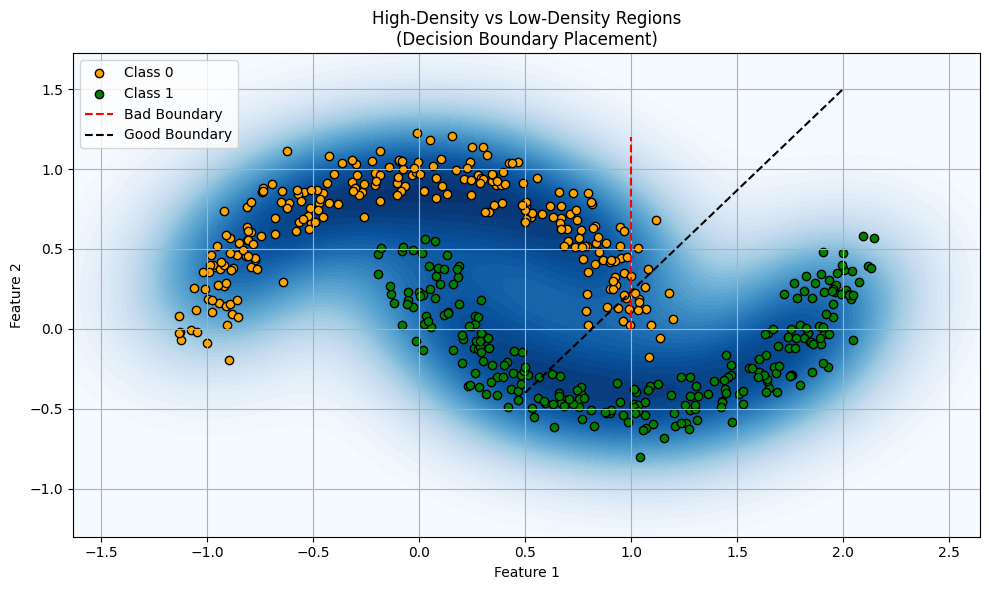

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.neighbors import KernelDensity

# Create synthetic 2D data (two moons)
X, y = make_moons(n_samples=500, noise=0.1, random_state=0)

# Estimate density using KDE
kde = KernelDensity(bandwidth=0.3, kernel='gaussian')
kde.fit(X)
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
                     np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
log_density = kde.score_samples(grid)
density = np.exp(log_density).reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, density, levels=50, cmap='Blues')
plt.scatter(X[y==0, 0], X[y==0, 1], color='orange', label='Class 0', edgecolor='k')
plt.scatter(X[y==1, 0], X[y==1, 1], color='green', label='Class 1', edgecolor='k')

# BAD decision boundary (through high-density region)
plt.plot([1.0, 1.0], [0, 1.2], 'r--', label='Bad Boundary')

# GOOD decision boundary (through low-density gap)
plt.plot([0.5, 2], [-0.4, 1.5], 'k--', label='Good Boundary')

plt.title("High-Density vs Low-Density Regions\n(Decision Boundary Placement)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cuda
Epoch 001 | Loss: 0.5667 | Acc: 0.7180
Epoch 002 | Loss: 0.3448 | Acc: 0.8210
Epoch 003 | Loss: 0.2524 | Acc: 0.8750
Epoch 004 | Loss: 0.1813 | Acc: 0.9180
Epoch 005 | Loss: 0.1381 | Acc: 0.9450
Epoch 006 | Loss: 0.1020 | Acc: 0.9630
Epoch 007 | Loss: 0.0700 | Acc: 0.9790
Epoch 008 | Loss: 0.0450 | Acc: 0.9910
Epoch 009 | Loss: 0.0320 | Acc: 0.9970
Epoch 010 | Loss: 0.0239 | Acc: 0.9980
Epoch 011 | Loss: 0.0215 | Acc: 0.9980
Epoch 012 | Loss: 0.0174 | Acc: 0.9970
Epoch 013 | Loss: 0.0152 | Acc: 0.9980
Epoch 014 | Loss: 0.0151 | Acc: 0.9980
Epoch 015 | Loss: 0.0182 | Acc: 0.9970
Epoch 016 | Loss: 0.0204 | Acc: 0.9980
Epoch 017 | Loss: 0.0180 | Acc: 0.9980
Epoch 018 | Loss: 0.0115 | Acc: 0.9980
Epoch 019 | Loss: 0.0152 | Acc: 0.9990
Epoch 020 | Loss: 0.0206 | Acc: 0.9980
Epoch 021 | Loss: 0.0170 | Acc: 0.9980
Epoch 022 | Loss: 0.0153 | Acc: 0.9980
Epoch 023 | Loss: 0.0175 | Acc: 0.9990
Epoch 024 | Loss: 0.0143 | Acc: 0.9980
Epoch 025 | Loss: 0.0123 | Acc: 0.9980
Epoch 

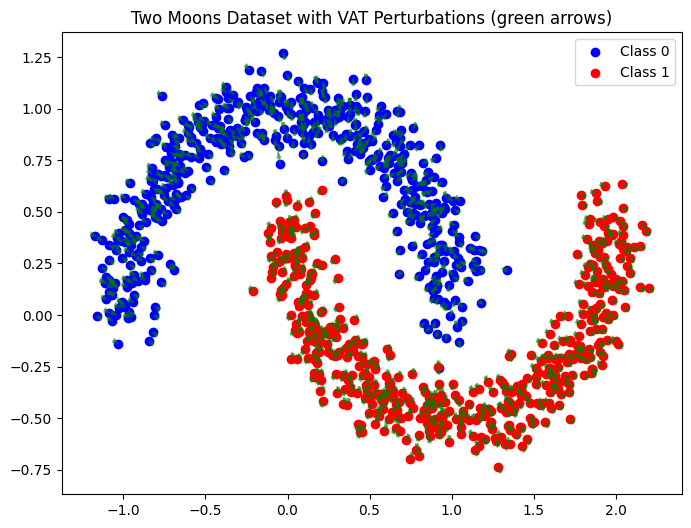

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Simple MLP for 2D inputs
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Generate two moons data
X, y = make_moons(n_samples=1000, noise=0.1, random_state=0)
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)

# VAT perturbation generation (simplified)
def generate_virtual_adversarial_perturbation(model, x, xi=1e-6, eps=0.3, ip=1, requires_grad=True):
    if requires_grad:
        pred = F.softmax(model(x), dim=1)
    else:
         with torch.no_grad():
             pred = F.softmax(model(x), dim=1)


    # Initialize random unit vector
    d = torch.randn_like(x, device=device)
    d = F.normalize(d, p=2, dim=1)

    for _ in range(ip):
        d.requires_grad_()
        pred_hat = model(x + xi * d)
        logp_hat = F.log_softmax(pred_hat, dim=1)
        adv_distance = F.kl_div(logp_hat, pred, reduction='batchmean')
        if requires_grad:
            adv_distance.backward()
            d = F.normalize(d.grad, p=2, dim=1).detach()
            model.zero_grad()
        else:
             # For visualization, we don't need to backpropagate through the model parameters
             d = F.normalize(torch.autograd.grad(adv_distance, d, create_graph=True)[0], p=2, dim=1).detach() # Keep create_graph=True for nested grad call

    r_adv = eps * d
    return r_adv


# Training parameters
lr = 0.01
epochs = 30
batch_size = 128

model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Simple batch loader
def get_batch(X, y, batch_size):
    n = X.shape[0]
    indices = torch.randperm(n)
    for i in range(0, n, batch_size):
        idx = indices[i:i+batch_size]
        yield X[idx], y[idx]

for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for xb, yb in get_batch(X, y, batch_size):
        optimizer.zero_grad()

        logits = model(xb)
        loss_sup = criterion(logits, yb)

        # VAT loss
        r_adv = generate_virtual_adversarial_perturbation(model, xb)
        logits_perturbed = model(xb + r_adv)

        p = F.softmax(logits.detach(), dim=1)
        log_p_hat = F.log_softmax(logits_perturbed, dim=1)
        loss_vat = F.kl_div(log_p_hat, p, reduction='batchmean')

        loss = loss_sup + loss_vat
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * yb.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total_samples += yb.size(0)

    print(f"Epoch {epoch+1:03d} | Loss: {total_loss/total_samples:.4f} | Acc: {total_correct/total_samples:.4f}")

# Visualization
model.eval()

# Plot data points
X_cpu = X.cpu().numpy()
y_cpu = y.cpu().numpy()

plt.figure(figsize=(8,6))
plt.scatter(X_cpu[y_cpu==0, 0], X_cpu[y_cpu==0, 1], c='blue', label='Class 0')
plt.scatter(X_cpu[y_cpu==1, 0], X_cpu[y_cpu==1, 1], c='red', label='Class 1')

# Compute VAT perturbations for all points for visualization (no grad needed)
r_adv_all = generate_virtual_adversarial_perturbation(model, X, requires_grad=False)
r_adv_all_cpu = r_adv_all.cpu().numpy()

# Plot perturbations as arrows
for i in range(len(X_cpu)):
    plt.arrow(X_cpu[i,0], X_cpu[i,1],
              r_adv_all_cpu[i,0], r_adv_all_cpu[i,1],
              color='green', alpha=0.5, head_width=0.02, length_includes_head=True)

plt.title("Two Moons Dataset with VAT Perturbations (green arrows)")
plt.legend()
plt.show()